# Exercise 06
# TensorFlow and Keras

Trabajo Presentado por:

#Ricardo Blanco   Codigo.   201727686  
#Alexandra Pinzon  Codigo.  201728019 


---

In [0]:
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_moons

%matplotlib inline

# Functions for plotting 2D data and decision regions

def plot_data(X, y):
    y_unique = np.unique(y)
    colors = pl.cm.rainbow(np.linspace(0.0, 1.0, y_unique.size))
    for this_y, color in zip(y_unique, colors):
        this_X = X[y == this_y]
        pl.scatter(this_X[:, 0], this_X[:, 1],  c=color,
                    alpha=0.5, edgecolor='k',
                    label="Class %s" % this_y)
    pl.legend(loc="best")
    pl.title("Data")

def plot_decision_region(X, pred_fun):
    min_x = np.min(X[:, 0])
    max_x = np.max(X[:, 0])
    min_y = np.min(X[:, 1])
    max_y = np.max(X[:, 1])
    min_x = min_x - (max_x - min_x) * 0.05
    max_x = max_x + (max_x - min_x) * 0.05
    min_y = min_y - (max_y - min_y) * 0.05
    max_y = max_y + (max_y - min_y) * 0.05
    x_vals = np.linspace(min_x, max_x, 30)
    y_vals = np.linspace(min_y, max_y, 30)
    XX, YY = np.meshgrid(x_vals, y_vals)
    grid_r, grid_c = XX.shape
    ZZ = np.zeros((grid_r, grid_c))
    for i in range(grid_r):
        for j in range(grid_c):
            ZZ[i, j] = pred_fun(XX[i, j], YY[i, j])
    pl.contourf(XX, YY, ZZ, 30, cmap = pl.cm.coolwarm, vmin= 0, vmax=1)
    pl.colorbar()
    pl.xlabel("x")
    pl.ylabel("y")

### 1. Multilayer neural network in TensorFlow

You need to create a neural network model in TF that is able to discriminate the two classes in the following dataset:

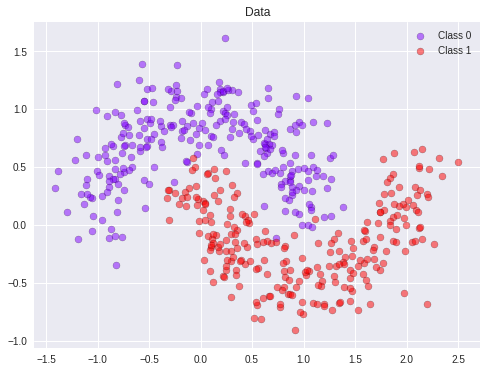

In [3]:
X, Y = make_moons(n_samples=1000, noise= 0.2, random_state=3)
x_train = X[:500]
x_test  = X[500:]
y_train = Y[:500]
y_test  = Y[500:]

pl.figure(figsize=(8, 6))
plot_data(x_train, y_train)

For this you will need to create a neural network with one hidden layer. You cannot use prebuilt models 
such as those in `tf.estimator`. **Hint**: extend the logistic regression example from the TensorFlow handout. 

Your answer must contain the following:
* A visualization of the CG of the model.
* A visualization of the decision region along with the test data.
* A snapshot from TensorBoard that shows the evolution of the training and test loss.

In [1]:
import tensorflow as tf
from IPython.display import clear_output, Image, display, HTML
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_blobs

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

    # Functions for plotting 2D data and decision regions

In [2]:
graph = tf.Graph()
n_h = 12 #Numero de neuronas en la capa oculta.
with graph.as_default():
    x = tf.placeholder(tf.float32,shape=[None,2])
    y_true = tf.placeholder(tf.float32,shape=None)
    
    with tf.name_scope('inference') as scope:
        w1 = tf.Variable(tf.random_normal((2,n_h)),dtype=tf.float32,name='weights_1')
        b1 = tf.Variable(tf.random_normal((1,n_h)),dtype=tf.float32,name='bias_1')
        w2 = tf.Variable(tf.random_normal((1,n_h)),dtype=tf.float32,name='weights_2')
        b2 = tf.Variable(tf.random_normal((1,1)),dtype=tf.float32,name='bias_2')
        h = tf.sigmoid(tf.matmul(x,w1)+b1)
        y_pred = tf.matmul(w2,tf.transpose(h)) + b2

    with tf.name_scope('loss') as scope:
        loss = tf.nn.sigmoid_cross_entropy_with_logits(labels=y_true,logits=y_pred)
        loss = tf.reduce_mean(loss)
  
    with tf.name_scope('train') as scope:
        learning_rate = 1.0
        optimizer = tf.train.GradientDescentOptimizer(learning_rate)
        train = optimizer.minimize(loss)

    init = tf.global_variables_initializer()

show_graph(graph.as_graph_def())

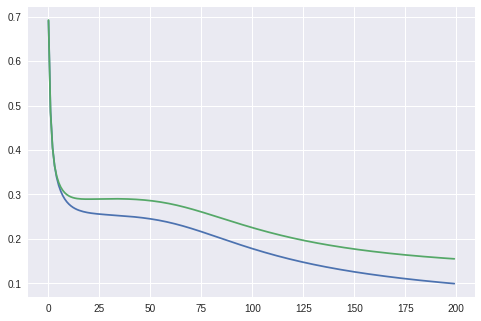

In [6]:
num_epochs = 1000
losses1 = []
losses2 = []

with graph.as_default():
    sess = tf.Session()
    sess.run(init)      
    for step in range(num_epochs):
        sess.run(train,{x: x_train, y_true: y_train})
        if (step % 5 == 0):
            losses1.append(sess.run(loss, {x: x_train, y_true: y_train}))
            losses2.append(sess.run(loss, {x: x_test, y_true: y_test}))
                       
pl.figure(figsize = (8,16/3))
pl.plot(losses1)
pl.plot(losses2)

###### La línea azul muestra como evoluciona al funcion de perdida de la muestra de entrenamiento, en verde la funcion de perdida en la muestra de test.

[[-1.5168566   0.97642833  1.1193721  -0.8538274   7.0703926   1.1454592
   1.0144545   0.95599043 -2.195293    1.0054293  -1.3223296  -0.95466715]
 [ 0.7396208  -0.79804707 -0.42596155  0.13360946  2.757998   -0.9777419
  -1.6500605  -1.6842588   2.0603404   2.400665    1.324979    1.2255899 ]]
[[-1.6699754   2.8503218   2.113838   -0.958382   -8.532138    2.314571
   3.298673    4.329903   -2.078701   -0.31046888 -2.4830847  -2.2904258 ]]
[[-10.82454]]


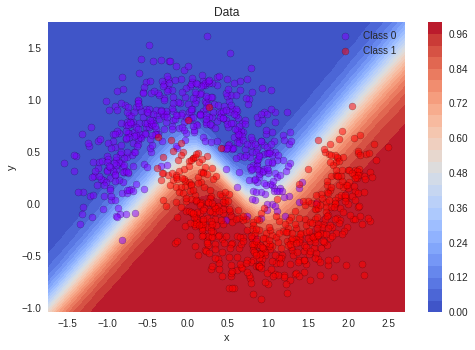

In [7]:
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))

with graph.as_default():
    wval1 = sess.run(w1)
    print(wval1)
    wval2 = sess.run(w2)
    print(wval2)
    
    result = sess.run(y_pred, {x:np.array([[1,2]])})
    print(result)
    def pred_fun(x1, x2):
        xval = np.array([[x1, x2]])
        return sigmoid(sess.run(y_pred,{x: xval}))

pl.figure(figsize = (8,16/3))    
plot_decision_region(X, pred_fun)
plot_data(X, Y)

###### La region de de clasificacion con una red neural de un capa oculta con 12 neuronas se adapta casi perfectamente.

### 2. Improving the Keras text classifier

Your goal is to improve the performance of the text classifier in the Keras handout. This is are the things that you need to try:

* Different activation functions for the hidden layer (https://keras.io/activations/)
* Different optimizers (https://keras.io/optimizers/)
* Add dropout between the hidden layer and the output layer (https://keras.io/layers/core/#dropout)
* Different initializers for the dense layers (https://keras.io/initializers/)

Try different combinations and report your findings at the end. Which configuration got the best accuracy in test?


### Diferentes funciones de activación para la capa oculta



In [8]:
from keras.datasets import reuters
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
import numpy as np
import pylab as pl
from sklearn.datasets.samples_generator import make_moons
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

max_words = 1000

print('Loading data...')
(x_train, y_train), (x_test, y_test) = reuters.load_data(num_words=max_words,
                                                         test_split=0.2)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

num_classes = np.max(y_train) + 1
print(num_classes, 'classes')

Using TensorFlow backend.


Loading data...
8982 train sequences
2246 test sequences
46 classes


In [9]:
word_index = reuters.get_word_index(path="reuters_word_index.json")
num_words = max(word_index.values()) + 1
words = ['']*num_words
for word in word_index:
    words[word_index[word]] = word
print([words[i-2] for i in x_train[101][1:]])

['', 'dlr', 'and', 'cts', '', '80', 'average', 'companies', 'in', 'income', 'of', 'make', '', '', 'said', '', '', 'a', 'of', 'make', '52', '', 'said', '', 'of', '1987', '', '2', 'of', 'sold', 'general', 'states', 'to', '', 'field', 'securities', 'was', 'agricultural', '', '3', 'it', 'a', '1988', 'said', 'as', 'april', '50', 'term', 'to', 'earlier', '3', 'it', 'but', 'was', 'with', '', 'said', '', 'previously', 'be', 'sell', 'cts', 'previously', 'be', '', 'more', 'earlier', 'of', 'which', 'and', 'said', 'commerce', 'of', '1987', 'was', '', 'august', '3', 'it', 'export', 'april', 'report', 'vice', 'to', 'beef', '3', 'it', '', 'and', '000', 'for']


In [10]:
tokenizer = Tokenizer(num_words=max_words)
x_train = tokenizer.sequences_to_matrix(x_train, mode='binary')
x_test = tokenizer.sequences_to_matrix(x_test, mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (8982, 1000)
x_test shape: (2246, 1000)


In [11]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

y_train shape: (8982, 46)
y_test shape: (2246, 46)


In [12]:
model = Sequential()
model.add(Dense(256, input_shape=(max_words,)))
model.add(Activation('sigmoid'))
model.add(Dense(num_classes))
model.add(Activation('softmax'))
model.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_1 (Dense)                (None, 256)                 256256     
______________________________________________________________________
activation_1 (Activation)      (None, 256)                 0          
______________________________________________________________________
dense_2 (Dense)                (None, 46)                  11822      
______________________________________________________________________
activation_2 (Activation)      (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [0]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [14]:
batch_size = 32
epochs = 5
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 156us/step - loss: 2.4542 - acc: 0.3630 - val_loss: 2.3069 - val_acc: 0.4260
Epoch 2/5
8083/8083 [==============================] - 1s 138us/step - loss: 2.1809 - acc: 0.4397 - val_loss: 2.1788 - val_acc: 0.4750
Epoch 3/5
8083/8083 [==============================] - 1s 139us/step - loss: 2.0693 - acc: 0.4876 - val_loss: 2.0863 - val_acc: 0.4905
Epoch 4/5
8083/8083 [==============================] - 1s 138us/step - loss: 1.9903 - acc: 0.5032 - val_loss: 2.0180 - val_acc: 0.5061
Epoch 5/5
8083/8083 [==============================] - 1s 139us/step - loss: 1.9276 - acc: 0.5163 - val_loss: 1.9608 - val_acc: 0.5150


In [15]:
score = model.evaluate(x_test, y_test)
print('Test score:', score[0])
print('Test accuracy:', score[1])

2246/2246 [==============================] - 0s 65us/step
Test score: 1.926467033761586
Test accuracy: 0.5258236865804117


### probando los diferentes tipos de activación capa oculta



* softmax
* relu
* tanh
* linear
* elu
* softsign
* selu
* hard_sigmoid



### softmax

In [16]:
M_softamax = Sequential()
M_softamax.add(Dense(256, input_shape=(max_words,)))
M_softamax.add(Activation('softmax'))
M_softamax.add(Dense(num_classes))
M_softamax.add(Activation('softmax'))
M_softamax.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_3 (Dense)                (None, 256)                 256256     
______________________________________________________________________
activation_3 (Activation)      (None, 256)                 0          
______________________________________________________________________
dense_4 (Dense)                (None, 46)                  11822      
______________________________________________________________________
activation_4 (Activation)      (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [0]:
M_softamax.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [18]:
batch_size = 32
epochs = 5
history = M_softamax.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 161us/step - loss: 3.6315 - acc: 0.3475 - val_loss: 3.4569 - val_acc: 0.3315
Epoch 2/5
8083/8083 [==============================] - 1s 143us/step - loss: 3.2789 - acc: 0.3540 - val_loss: 3.1575 - val_acc: 0.3315
Epoch 3/5
8083/8083 [==============================] - 1s 144us/step - loss: 3.0113 - acc: 0.3540 - val_loss: 2.9468 - val_acc: 0.3315
Epoch 4/5
8083/8083 [==============================] - 1s 142us/step - loss: 2.8327 - acc: 0.3540 - val_loss: 2.8144 - val_acc: 0.3315
Epoch 5/5
8083/8083 [==============================] - 1s 141us/step - loss: 2.7230 - acc: 0.3540 - val_loss: 2.7342 - val_acc: 0.3315


In [19]:
score_softmax = M_softamax.evaluate(x_test, y_test)
print('Test score:', score_softmax[0])
print('Test accuracy:', score_softmax[1])

2246/2246 [==============================] - 0s 67us/step
Test score: 2.6777455827962684
Test accuracy: 0.36197684778237277


### relu

In [20]:
M_relu = Sequential()
M_relu.add(Dense(256, input_shape=(max_words,)))
M_relu.add(Activation('relu'))
M_relu.add(Dense(num_classes))
M_relu.add(Activation('softmax'))
M_relu.summary(70)

______________________________________________________________________
Layer (type)                   Output Shape                Param #    
dense_5 (Dense)                (None, 256)                 256256     
______________________________________________________________________
activation_5 (Activation)      (None, 256)                 0          
______________________________________________________________________
dense_6 (Dense)                (None, 46)                  11822      
______________________________________________________________________
activation_6 (Activation)      (None, 46)                  0          
Total params: 268,078
Trainable params: 268,078
Non-trainable params: 0
______________________________________________________________________


In [0]:
M_relu.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [22]:
batch_size = 32
epochs = 5
history = M_relu.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 158us/step - loss: 2.4796 - acc: 0.4595 - val_loss: 1.9839 - val_acc: 0.5139
Epoch 2/5
8083/8083 [==============================] - 1s 139us/step - loss: 1.7881 - acc: 0.5581 - val_loss: 1.7584 - val_acc: 0.5907
Epoch 3/5
8083/8083 [==============================] - 1s 141us/step - loss: 1.6135 - acc: 0.6138 - val_loss: 1.6383 - val_acc: 0.6363
Epoch 4/5
8083/8083 [==============================] - 1s 141us/step - loss: 1.4953 - acc: 0.6566 - val_loss: 1.5516 - val_acc: 0.6652
Epoch 5/5
8083/8083 [==============================] - 1s 139us/step - loss: 1.4022 - acc: 0.6830 - val_loss: 1.4841 - val_acc: 0.6830


In [23]:
score_relu = M_relu.evaluate(x_test, y_test)
print('Test score:', score_relu[0])
print('Test accuracy:', score_relu[1])

2246/2246 [==============================] - 0s 66us/step
Test score: 1.460702963206562
Test accuracy: 0.6749777382277848


### tanh

In [0]:
M_tanh = Sequential()
M_tanh.add(Dense(256, input_shape=(max_words,)))
M_tanh.add(Activation('tanh'))
M_tanh.add(Dense(num_classes))
M_tanh.add(Activation('softmax'))
#model_elu.summary(70)

In [0]:
M_tanh.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [26]:
batch_size = 32
epochs = 5
history = M_tanh.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 160us/step - loss: 2.2105 - acc: 0.4865 - val_loss: 1.8361 - val_acc: 0.5451
Epoch 2/5
8083/8083 [==============================] - 1s 138us/step - loss: 1.6702 - acc: 0.5945 - val_loss: 1.6419 - val_acc: 0.6207
Epoch 3/5
8083/8083 [==============================] - 1s 140us/step - loss: 1.5056 - acc: 0.6573 - val_loss: 1.5246 - val_acc: 0.6674
Epoch 4/5
8083/8083 [==============================] - 1s 138us/step - loss: 1.3938 - acc: 0.6900 - val_loss: 1.4466 - val_acc: 0.6874
Epoch 5/5
8083/8083 [==============================] - 1s 140us/step - loss: 1.3087 - acc: 0.7120 - val_loss: 1.3864 - val_acc: 0.6986


In [27]:
score_tanh = M_tanh.evaluate(x_test, y_test)
print('Test score:', score_tanh[0])
print('Test accuracy:', score_tanh[1])

2246/2246 [==============================] - 0s 64us/step
Test score: 1.3789814093870874
Test accuracy: 0.6905609973551223


### linear

In [0]:
M_linear = Sequential()
M_linear.add(Dense(256, input_shape=(max_words,)))
M_linear.add(Activation('linear'))
M_linear.add(Dense(num_classes))
M_linear.add(Activation('softmax'))
#model_elu.summary(70)

In [0]:
M_linear.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [30]:
batch_size = 32
epochs = 5
history = M_linear.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 161us/step - loss: 2.1693 - acc: 0.4951 - val_loss: 1.8140 - val_acc: 0.5617
Epoch 2/5
8083/8083 [==============================] - 1s 137us/step - loss: 1.6270 - acc: 0.6188 - val_loss: 1.6128 - val_acc: 0.6407
Epoch 3/5
8083/8083 [==============================] - 1s 138us/step - loss: 1.4580 - acc: 0.6686 - val_loss: 1.5002 - val_acc: 0.6674
Epoch 4/5
8083/8083 [==============================] - 1s 139us/step - loss: 1.3458 - acc: 0.6960 - val_loss: 1.4216 - val_acc: 0.6863
Epoch 5/5
8083/8083 [==============================] - 1s 139us/step - loss: 1.2620 - acc: 0.7209 - val_loss: 1.3699 - val_acc: 0.7052


In [31]:
score_linear = M_linear.evaluate(x_test, y_test)
print('Test score:', score_linear[0])
print('Test accuracy:', score_linear[1])

2246/2246 [==============================] - 0s 67us/step
Test score: 1.342974031173217
Test accuracy: 0.7079252003827269


### elu

In [0]:
M_elu = Sequential()
M_elu.add(Dense(256, input_shape=(max_words,)))
M_elu.add(Activation('elu'))
M_elu.add(Dense(num_classes))
M_elu.add(Activation('softmax'))
#model_elu.summary(70)

In [0]:
M_elu.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [34]:
batch_size = 32
epochs = 5
history = M_elu.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 165us/step - loss: 2.2325 - acc: 0.5034 - val_loss: 1.8474 - val_acc: 0.5439
Epoch 2/5
8083/8083 [==============================] - 1s 139us/step - loss: 1.6604 - acc: 0.6039 - val_loss: 1.6544 - val_acc: 0.6218
Epoch 3/5
8083/8083 [==============================] - 1s 143us/step - loss: 1.4976 - acc: 0.6563 - val_loss: 1.5438 - val_acc: 0.6674
Epoch 4/5
8083/8083 [==============================] - 1s 142us/step - loss: 1.3875 - acc: 0.6842 - val_loss: 1.4662 - val_acc: 0.6841
Epoch 5/5
8083/8083 [==============================] - 1s 141us/step - loss: 1.3029 - acc: 0.7073 - val_loss: 1.4070 - val_acc: 0.6952


In [35]:
score_elu = M_elu.evaluate(x_test, y_test)
print('Test score:', score_elu[0])
print('Test accuracy:', score_elu[1])

2246/2246 [==============================] - 0s 67us/step
Test score: 1.375299228055076
Test accuracy: 0.6941228851556566


### softsign

In [0]:
M_softsign = Sequential()
M_softsign.add(Dense(256, input_shape=(max_words,)))
M_softsign.add(Activation('softsign'))
M_softsign.add(Dense(num_classes))
M_softsign.add(Activation('softmax'))
#model_elu.summary(70)

In [0]:
M_softsign.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [38]:
batch_size = 32
epochs = 5
history = M_softsign.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 167us/step - loss: 2.4468 - acc: 0.4540 - val_loss: 2.0132 - val_acc: 0.5072
Epoch 2/5
8083/8083 [==============================] - 1s 139us/step - loss: 1.8268 - acc: 0.5487 - val_loss: 1.7939 - val_acc: 0.5617
Epoch 3/5
8083/8083 [==============================] - 1s 139us/step - loss: 1.6640 - acc: 0.6029 - val_loss: 1.6775 - val_acc: 0.6129
Epoch 4/5
8083/8083 [==============================] - 1s 139us/step - loss: 1.5571 - acc: 0.6436 - val_loss: 1.5947 - val_acc: 0.6574
Epoch 5/5
8083/8083 [==============================] - 1s 140us/step - loss: 1.4742 - acc: 0.6688 - val_loss: 1.5324 - val_acc: 0.6707


In [39]:
score_softsign = M_softsign.evaluate(x_test, y_test)
print('Test score:', score_softsign[0])
print('Test accuracy:', score_softsign[1])

2246/2246 [==============================] - 0s 67us/step
Test score: 1.5121521189715963
Test accuracy: 0.6593944791004474


### Selu

In [0]:
M_selu = Sequential()
M_selu.add(Dense(256, input_shape=(max_words,)))
M_selu.add(Activation('selu'))
M_selu.add(Dense(num_classes))
M_selu.add(Activation('softmax'))
#model_elu.summary(70)

In [0]:
M_selu.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [42]:
batch_size = 32
epochs = 5
history = M_selu.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 177us/step - loss: 2.0513 - acc: 0.5163 - val_loss: 1.6809 - val_acc: 0.6018
Epoch 2/5
8083/8083 [==============================] - 1s 147us/step - loss: 1.5123 - acc: 0.6551 - val_loss: 1.4941 - val_acc: 0.6574
Epoch 3/5
8083/8083 [==============================] - 1s 146us/step - loss: 1.3434 - acc: 0.6966 - val_loss: 1.3897 - val_acc: 0.6941
Epoch 4/5
8083/8083 [==============================] - 1s 146us/step - loss: 1.2335 - acc: 0.7256 - val_loss: 1.3208 - val_acc: 0.7063
Epoch 5/5
8083/8083 [==============================] - 1s 147us/step - loss: 1.1515 - acc: 0.7461 - val_loss: 1.2741 - val_acc: 0.7086


In [43]:
score_selu = M_selu.evaluate(x_test, y_test)
print('Test score:', score_selu[0])
print('Test accuracy:', score_selu[1])

2246/2246 [==============================] - 0s 68us/step
Test score: 1.260794273785789
Test accuracy: 0.7154942119323241


### hard_sigmoid

In [0]:
M_hard_sigmoid = Sequential()
M_hard_sigmoid.add(Dense(256, input_shape=(max_words,)))
M_hard_sigmoid.add(Activation('hard_sigmoid'))
M_hard_sigmoid.add(Dense(num_classes))
M_hard_sigmoid.add(Activation('softmax'))
#model_elu.summary(70)

In [0]:
M_hard_sigmoid.compile(loss='categorical_crossentropy',
              optimizer=SGD(),
              metrics=['accuracy'])

In [46]:
batch_size = 32
epochs = 5
history = M_hard_sigmoid.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 185us/step - loss: 2.4607 - acc: 0.3582 - val_loss: 2.3594 - val_acc: 0.3393
Epoch 2/5
8083/8083 [==============================] - 1s 149us/step - loss: 2.2431 - acc: 0.3922 - val_loss: 2.2595 - val_acc: 0.3782
Epoch 3/5
8083/8083 [==============================] - 1s 148us/step - loss: 2.1468 - acc: 0.4401 - val_loss: 2.1718 - val_acc: 0.4372
Epoch 4/5
8083/8083 [==============================] - 1s 152us/step - loss: 2.0714 - acc: 0.4749 - val_loss: 2.1024 - val_acc: 0.4861
Epoch 5/5
8083/8083 [==============================] - 1s 147us/step - loss: 2.0104 - acc: 0.4949 - val_loss: 2.0467 - val_acc: 0.4928


In [47]:
score_hard_sigmoid = M_hard_sigmoid.evaluate(x_test, y_test)
print('Test score:', score_hard_sigmoid[0])
print('Test accuracy:', score_hard_sigmoid[1])

2246/2246 [==============================] - 0s 67us/step
Test score: 2.0003642010455245
Test accuracy: 0.5102404274530742


### Resultados

In [48]:
print('Test accuracy elu:', score_elu[1])
print('Test accuracy relu:', score_relu[1])
print('Test accuracy linear:', score_linear[1])
print('Test accuracy tanh:', score_tanh[1])
print('Test accuracysoftmax :', score_softmax[1])
print('Test accuracy sigmoid:', score[1])
print('Test accuracy selu:', score_softsign[1])
print('Test accuracy selu:', score_selu[1])
print('Test accuracy selu:', score_hard_sigmoid[1])

Test accuracy elu: 0.6941228851556566
Test accuracy relu: 0.6749777382277848
Test accuracy linear: 0.7079252003827269
Test accuracy tanh: 0.6905609973551223
Test accuracysoftmax : 0.36197684778237277
Test accuracy sigmoid: 0.5258236865804117
Test accuracy selu: 0.6593944791004474
Test accuracy selu: 0.7154942119323241
Test accuracy selu: 0.5102404274530742


### optimizadores
* RMSprop
* Adagrad
* Adadelta
* Adam
* Adamax
* Nadam


### RMSprop

In [0]:
M_2_RMSprop = Sequential()
M_2_RMSprop.add(Dense(256, input_shape=(max_words,)))
M_2_RMSprop.add(Activation('linear'))
M_2_RMSprop.add(Dense(num_classes))
M_2_RMSprop.add(Activation('softmax'))


In [0]:
from keras.optimizers import RMSprop
M_2_RMSprop.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [51]:
batch_size = 32
epochs = 5
history = M_2_RMSprop.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 189us/step - loss: 1.2047 - acc: 0.7343 - val_loss: 1.0158 - val_acc: 0.7764
Epoch 2/5
8083/8083 [==============================] - 1s 152us/step - loss: 0.6597 - acc: 0.8528 - val_loss: 0.9411 - val_acc: 0.7887
Epoch 3/5
8083/8083 [==============================] - 1s 155us/step - loss: 0.4766 - acc: 0.8916 - val_loss: 0.9470 - val_acc: 0.7964
Epoch 4/5
8083/8083 [==============================] - 1s 153us/step - loss: 0.3821 - acc: 0.9106 - val_loss: 0.9967 - val_acc: 0.7964
Epoch 5/5
8083/8083 [==============================] - 1s 153us/step - loss: 0.3202 - acc: 0.9224 - val_loss: 1.0661 - val_acc: 0.7831


In [52]:
score_2_RMSprop = M_2_RMSprop.evaluate(x_test, y_test)
print('Test score:', score_2_RMSprop[0])
print('Test accuracy:', score_2_RMSprop[1])

2246/2246 [==============================] - 0s 67us/step
Test score: 1.0080740876422858
Test accuracy: 0.784951024095819


### Adagrad

In [0]:
M_2_Adagrad = Sequential()
M_2_Adagrad.add(Dense(256, input_shape=(max_words,)))
M_2_Adagrad.add(Activation('linear'))
M_2_Adagrad.add(Dense(num_classes))
M_2_Adagrad.add(Activation('softmax'))


In [0]:
from keras.optimizers import Adagrad
M_2_Adagrad.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])

In [55]:
batch_size = 32
epochs = 5
history = M_2_Adagrad.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 1s 185us/step - loss: 1.0976 - acc: 0.7537 - val_loss: 0.9623 - val_acc: 0.7864
Epoch 2/5
8083/8083 [==============================] - 1s 148us/step - loss: 0.5924 - acc: 0.8689 - val_loss: 0.9021 - val_acc: 0.7964
Epoch 3/5
8083/8083 [==============================] - 1s 147us/step - loss: 0.4656 - acc: 0.8986 - val_loss: 0.8821 - val_acc: 0.7931
Epoch 4/5
8083/8083 [==============================] - 1s 148us/step - loss: 0.3926 - acc: 0.9120 - val_loss: 0.8792 - val_acc: 0.8031
Epoch 5/5
8083/8083 [==============================] - 1s 149us/step - loss: 0.3450 - acc: 0.9226 - val_loss: 0.8990 - val_acc: 0.8020


In [56]:
score_2_Adagrad = M_2_Adagrad.evaluate(x_test, y_test)
print('Test score:', score_2_Adagrad[0])
print('Test accuracy:', score_2_Adagrad[1])

2246/2246 [==============================] - 0s 68us/step
Test score: 0.8709023898983257
Test accuracy: 0.7983081032947462


### Adadelta

In [0]:
M_2_Adadelta = Sequential()
M_2_Adadelta.add(Dense(256, input_shape=(max_words,)))
M_2_Adadelta.add(Activation('linear'))
M_2_Adadelta.add(Dense(num_classes))
M_2_Adadelta.add(Activation('softmax'))


In [0]:
from keras.optimizers import Adadelta
M_2_Adadelta.compile(loss='categorical_crossentropy',
              optimizer=Adadelta(),
              metrics=['accuracy'])

In [59]:
batch_size = 32
epochs = 5
history = M_2_Adadelta.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 222us/step - loss: 1.2745 - acc: 0.7171 - val_loss: 1.0567 - val_acc: 0.7742
Epoch 2/5
8083/8083 [==============================] - 1s 176us/step - loss: 0.7227 - acc: 0.8368 - val_loss: 0.9723 - val_acc: 0.7920
Epoch 3/5
8083/8083 [==============================] - 1s 174us/step - loss: 0.5376 - acc: 0.8780 - val_loss: 0.9294 - val_acc: 0.8087
Epoch 4/5
8083/8083 [==============================] - 1s 174us/step - loss: 0.4312 - acc: 0.8997 - val_loss: 0.9357 - val_acc: 0.8009
Epoch 5/5
8083/8083 [==============================] - 1s 173us/step - loss: 0.3602 - acc: 0.9172 - val_loss: 0.9967 - val_acc: 0.7998


In [60]:
score_2_Adadelta = M_2_Adadelta.evaluate(x_test, y_test)
print('Test score:', score_2_Adadelta[0])
print('Test accuracy:', score_2_Adadelta[1])

2246/2246 [==============================] - 0s 68us/step
Test score: 0.9412477954837327
Test accuracy: 0.7853962600708857


### Adam

In [0]:
M_2_Adam = Sequential()
M_2_Adam.add(Dense(256, input_shape=(max_words,)))
M_2_Adam.add(Activation('linear'))
M_2_Adam.add(Dense(num_classes))
M_2_Adam.add(Activation('softmax'))


In [0]:
from keras.optimizers import Adam
M_2_Adam.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [63]:
batch_size = 32
epochs = 5
history = M_2_Adam.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 216us/step - loss: 1.2395 - acc: 0.7288 - val_loss: 1.0152 - val_acc: 0.7720
Epoch 2/5
8083/8083 [==============================] - 1s 168us/step - loss: 0.6331 - acc: 0.8588 - val_loss: 0.8911 - val_acc: 0.7964
Epoch 3/5
8083/8083 [==============================] - 1s 167us/step - loss: 0.4449 - acc: 0.8976 - val_loss: 0.9059 - val_acc: 0.7976
Epoch 4/5
8083/8083 [==============================] - 1s 169us/step - loss: 0.3528 - acc: 0.9157 - val_loss: 0.9442 - val_acc: 0.7931
Epoch 5/5
8083/8083 [==============================] - 1s 167us/step - loss: 0.2924 - acc: 0.9276 - val_loss: 0.9676 - val_acc: 0.7987


In [64]:
score_2_Adam = M_2_Adam.evaluate(x_test, y_test)
print('Test score:', score_2_Adam[0])
print('Test accuracy:', score_2_Adam[1])

2246/2246 [==============================] - 0s 69us/step
Test score: 0.9827050260423233
Test accuracy: 0.786731967996086


### Adamax

In [0]:
M_2_Adamax = Sequential()
M_2_Adamax.add(Dense(256, input_shape=(max_words,)))
M_2_Adamax.add(Activation('linear'))
M_2_Adamax.add(Dense(num_classes))
M_2_Adamax.add(Activation('softmax'))


In [0]:
from keras.optimizers import Adamax
M_2_Adamax.compile(loss='categorical_crossentropy',
              optimizer=Adamax(),
              metrics=['accuracy'])

In [67]:
batch_size = 32
epochs = 5
history = M_2_Adamax.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 208us/step - loss: 1.3023 - acc: 0.7171 - val_loss: 1.1108 - val_acc: 0.7531
Epoch 2/5
8083/8083 [==============================] - 1s 156us/step - loss: 0.7759 - acc: 0.8227 - val_loss: 0.9804 - val_acc: 0.7864
Epoch 3/5
8083/8083 [==============================] - 1s 160us/step - loss: 0.5905 - acc: 0.8675 - val_loss: 0.9584 - val_acc: 0.7786
Epoch 4/5
8083/8083 [==============================] - 1s 159us/step - loss: 0.4745 - acc: 0.8927 - val_loss: 0.9420 - val_acc: 0.7842
Epoch 5/5
8083/8083 [==============================] - 1s 158us/step - loss: 0.3959 - acc: 0.9113 - val_loss: 0.9308 - val_acc: 0.7942


In [68]:
score_2_Adamax = M_2_Adamax.evaluate(x_test, y_test)
print('Test score:', score_2_Adamax[0])
print('Test accuracy:', score_2_Adamax[1])

2246/2246 [==============================] - 0s 70us/step
Test score: 0.8965486303993558
Test accuracy: 0.7929652715939448


### Nadam

In [0]:
M_2_Nadam = Sequential()
M_2_Nadam.add(Dense(256, input_shape=(max_words,)))
M_2_Nadam.add(Activation('linear'))
M_2_Nadam.add(Dense(num_classes))
M_2_Nadam.add(Activation('softmax'))


In [0]:
from keras.optimizers import Nadam
M_2_Nadam.compile(loss='categorical_crossentropy',
              optimizer=Nadam(),
              metrics=['accuracy'])

In [71]:
batch_size = 32
epochs = 5
history = M_2_Nadam.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 250us/step - loss: 1.1082 - acc: 0.7498 - val_loss: 0.9278 - val_acc: 0.7887
Epoch 2/5
8083/8083 [==============================] - 2s 191us/step - loss: 0.5332 - acc: 0.8739 - val_loss: 0.9310 - val_acc: 0.7875
Epoch 3/5
8083/8083 [==============================] - 2s 189us/step - loss: 0.3872 - acc: 0.9083 - val_loss: 1.0037 - val_acc: 0.7976
Epoch 4/5
8083/8083 [==============================] - 2s 189us/step - loss: 0.3337 - acc: 0.9245 - val_loss: 1.0791 - val_acc: 0.7920
Epoch 5/5
8083/8083 [==============================] - 2s 186us/step - loss: 0.2983 - acc: 0.9312 - val_loss: 1.1432 - val_acc: 0.7864


In [72]:
score_2_Nadam = M_2_Nadam.evaluate(x_test, y_test)
print('Test score:', score_2_Nadam[0])
print('Test accuracy:', score_2_Nadam[1])

2246/2246 [==============================] - 0s 67us/step
Test score: 1.1273309004062642
Test accuracy: 0.7778272484947504


### Resultados

In [73]:
print('Test accuracy score_2_RMSprop:', score_2_RMSprop[1])
print('Test accuracy Adagrad:', score_2_Adagrad[1])
print('Test accuracy Adadelta:', score_2_Adadelta[1])
print('Test accuracy Adam:', score_2_Adam[1])
print('Test accuracy Adamax:', score_2_Adamax[1])
print('Test accuracy Nadam:', score_2_Nadam[1])


Test accuracy score_2_RMSprop: 0.784951024095819
Test accuracy Adagrad: 0.7983081032947462
Test accuracy Adadelta: 0.7853962600708857
Test accuracy Adam: 0.786731967996086
Test accuracy Adamax: 0.7929652715939448
Test accuracy Nadam: 0.7778272484947504


### DROPOUT




In [0]:
M_3_dropout = Sequential()
M_3_dropout.add(Dense(256, input_shape=(max_words,)))
M_3_dropout.add(Activation('linear'))
M_3_dropout.add(Dropout(0.5))
M_3_dropout.add(Dense(num_classes))
M_3_dropout.add(Activation('softmax'))


In [0]:

M_3_dropout.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])

In [76]:
batch_size = 32
epochs = 5
history = M_3_dropout.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 215us/step - loss: 1.2271 - acc: 0.7304 - val_loss: 1.0405 - val_acc: 0.7764
Epoch 2/5
8083/8083 [==============================] - 1s 160us/step - loss: 0.7671 - acc: 0.8303 - val_loss: 0.9605 - val_acc: 0.7909
Epoch 3/5
8083/8083 [==============================] - 1s 159us/step - loss: 0.6292 - acc: 0.8591 - val_loss: 0.9272 - val_acc: 0.7875
Epoch 4/5
8083/8083 [==============================] - 1s 159us/step - loss: 0.5508 - acc: 0.8716 - val_loss: 0.9148 - val_acc: 0.7931
Epoch 5/5
8083/8083 [==============================] - 1s 160us/step - loss: 0.4978 - acc: 0.8878 - val_loss: 0.9033 - val_acc: 0.7987


In [77]:
score_3_dropout = M_3_dropout.evaluate(x_test, y_test)
print('Test score:', score_3_dropout[0])
print('Test accuracy:', score_3_dropout[1])

2246/2246 [==============================] - 0s 69us/step
Test score: 0.8633639196784817
Test accuracy: 0.8005342831700801


### inicializador capa denza

* RandomUniform
* RandomNormal
* TruncatedNormal
* VarianceScaling
* Initializer
* Zeros


### score_4_RandomUniform

In [0]:
M_4_RandomUniform = Sequential()
M_4_RandomUniform.add(Dense(256, input_shape=(max_words,),kernel_initializer = 'RandomUniform'))
M_4_RandomUniform.add(Activation('linear'))
M_4_RandomUniform.add(Dropout(0.5))
M_4_RandomUniform.add(Dense(num_classes))
M_4_RandomUniform.add(Activation('softmax'))


In [0]:

M_4_RandomUniform.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])

In [80]:
batch_size = 32
epochs = 5
history = M_4_RandomUniform.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 242us/step - loss: 1.2077 - acc: 0.7366 - val_loss: 1.0305 - val_acc: 0.7742
Epoch 2/5
8083/8083 [==============================] - 1s 159us/step - loss: 0.7465 - acc: 0.8347 - val_loss: 0.9410 - val_acc: 0.7875
Epoch 3/5
8083/8083 [==============================] - 1s 160us/step - loss: 0.6217 - acc: 0.8592 - val_loss: 0.9161 - val_acc: 0.7887
Epoch 4/5
8083/8083 [==============================] - 1s 160us/step - loss: 0.5432 - acc: 0.8775 - val_loss: 0.9036 - val_acc: 0.7964
Epoch 5/5
8083/8083 [==============================] - 1s 159us/step - loss: 0.4856 - acc: 0.8901 - val_loss: 0.8988 - val_acc: 0.7976


In [81]:
score_4_RandomUniform = M_4_RandomUniform.evaluate(x_test, y_test)
print('Test score:', score_4_RandomUniform[0])
print('Test accuracy:', score_4_RandomUniform[1])

2246/2246 [==============================] - 0s 68us/step
Test score: 0.867332745744836
Test accuracy: 0.8032056990204809


### RandomNormal

In [0]:
M_4_RandomNormal = Sequential()
M_4_RandomNormal.add(Dense(256, input_shape=(max_words,),kernel_initializer = 'RandomNormal'))
M_4_RandomNormal.add(Activation('linear'))
M_4_RandomNormal.add(Dropout(0.5))
M_4_RandomNormal.add(Dense(num_classes))
M_4_RandomNormal.add(Activation('softmax'))


In [0]:

M_4_RandomNormal.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])

In [84]:
batch_size = 32
epochs = 5
history = M_4_RandomNormal.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 221us/step - loss: 1.2692 - acc: 0.7214 - val_loss: 1.0371 - val_acc: 0.7664
Epoch 2/5
8083/8083 [==============================] - 1s 159us/step - loss: 0.7784 - acc: 0.8242 - val_loss: 0.9673 - val_acc: 0.7764
Epoch 3/5
8083/8083 [==============================] - 1s 157us/step - loss: 0.6501 - acc: 0.8491 - val_loss: 0.9242 - val_acc: 0.7864
Epoch 4/5
8083/8083 [==============================] - 1s 157us/step - loss: 0.5778 - acc: 0.8640 - val_loss: 0.9061 - val_acc: 0.7976
Epoch 5/5
8083/8083 [==============================] - 1s 159us/step - loss: 0.5217 - acc: 0.8754 - val_loss: 0.9010 - val_acc: 0.7998


In [85]:
score_4_RandomNormal = M_4_RandomNormal.evaluate(x_test, y_test)
print('Test score:', score_4_RandomNormal[0])
print('Test accuracy:', score_4_RandomNormal[1])

2246/2246 [==============================] - 0s 69us/step
Test score: 0.8564965259996994
Test accuracy: 0.804986642920748


### TruncatedNormal

In [0]:
M_4_TruncatedNormal = Sequential()
M_4_TruncatedNormal.add(Dense(256, input_shape=(max_words,),kernel_initializer = 'TruncatedNormal'))
M_4_TruncatedNormal.add(Activation('linear'))
M_4_TruncatedNormal.add(Dropout(0.5))
M_4_TruncatedNormal.add(Dense(num_classes))
M_4_TruncatedNormal.add(Activation('softmax'))


In [0]:

M_4_TruncatedNormal.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])

In [88]:
batch_size = 32
epochs = 5
history = M_4_TruncatedNormal.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 229us/step - loss: 1.2483 - acc: 0.7226 - val_loss: 1.0328 - val_acc: 0.7798
Epoch 2/5
8083/8083 [==============================] - 1s 162us/step - loss: 0.7712 - acc: 0.8268 - val_loss: 0.9559 - val_acc: 0.7942
Epoch 3/5
8083/8083 [==============================] - 1s 163us/step - loss: 0.6450 - acc: 0.8551 - val_loss: 0.9278 - val_acc: 0.8031
Epoch 4/5
8083/8083 [==============================] - 1s 160us/step - loss: 0.5668 - acc: 0.8695 - val_loss: 0.9072 - val_acc: 0.8053
Epoch 5/5
8083/8083 [==============================] - 1s 163us/step - loss: 0.5182 - acc: 0.8814 - val_loss: 0.9054 - val_acc: 0.8087


In [89]:
score_4_TruncatedNormal = M_4_TruncatedNormal.evaluate(x_test, y_test)
print('Test score:', score_4_TruncatedNormal[0])
print('Test accuracy:', score_4_TruncatedNormal[1])

2246/2246 [==============================] - 0s 70us/step
Test score: 0.8665867153279821
Test accuracy: 0.7969723953695459


### VarianceScaling

In [0]:
M_4_VarianceScaling = Sequential()
M_4_VarianceScaling.add(Dense(256, input_shape=(max_words,),kernel_initializer = 'VarianceScaling'))
M_4_VarianceScaling.add(Activation('linear'))
M_4_VarianceScaling.add(Dropout(0.5))
M_4_VarianceScaling.add(Dense(num_classes))
M_4_VarianceScaling.add(Activation('softmax'))


In [0]:

M_4_VarianceScaling.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])

In [92]:
batch_size = 32
epochs = 5
history = M_4_VarianceScaling.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 231us/step - loss: 1.2171 - acc: 0.7340 - val_loss: 1.0307 - val_acc: 0.7764
Epoch 2/5
8083/8083 [==============================] - 1s 158us/step - loss: 0.7457 - acc: 0.8336 - val_loss: 0.9423 - val_acc: 0.7898
Epoch 3/5
8083/8083 [==============================] - 1s 158us/step - loss: 0.6134 - acc: 0.8590 - val_loss: 0.9141 - val_acc: 0.8031
Epoch 4/5
8083/8083 [==============================] - 1s 159us/step - loss: 0.5409 - acc: 0.8796 - val_loss: 0.9072 - val_acc: 0.7920
Epoch 5/5
8083/8083 [==============================] - 1s 160us/step - loss: 0.4843 - acc: 0.8877 - val_loss: 0.8826 - val_acc: 0.7976


In [93]:
score_4_VarianceScaling = M_4_VarianceScaling.evaluate(x_test, y_test)
print('Test score:', score_4_VarianceScaling[0])
print('Test accuracy:', score_4_VarianceScaling[1])

2246/2246 [==============================] - 0s 73us/step
Test score: 0.8601760339864322
Test accuracy: 0.7996438112464848


### lecun_uniform

In [0]:
M_4_lecun_uniform = Sequential()
M_4_lecun_uniform.add(Dense(256, input_shape=(max_words,),kernel_initializer = 'lecun_uniform'))
M_4_lecun_uniform.add(Activation('linear'))
M_4_lecun_uniform.add(Dropout(0.5))
M_4_lecun_uniform.add(Dense(num_classes))
M_4_lecun_uniform.add(Activation('softmax'))


In [0]:

M_4_lecun_uniform.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])

In [96]:
batch_size = 32
epochs = 5
history = M_4_lecun_uniform.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 247us/step - loss: 1.2154 - acc: 0.7308 - val_loss: 1.0254 - val_acc: 0.7731
Epoch 2/5
8083/8083 [==============================] - 1s 159us/step - loss: 0.7494 - acc: 0.8317 - val_loss: 0.9336 - val_acc: 0.7964
Epoch 3/5
8083/8083 [==============================] - 1s 160us/step - loss: 0.6231 - acc: 0.8577 - val_loss: 0.9222 - val_acc: 0.7976
Epoch 4/5
8083/8083 [==============================] - 1s 159us/step - loss: 0.5466 - acc: 0.8768 - val_loss: 0.8877 - val_acc: 0.8009
Epoch 5/5
8083/8083 [==============================] - 1s 161us/step - loss: 0.4906 - acc: 0.8867 - val_loss: 0.8765 - val_acc: 0.8065


In [97]:
score_4_lecun_uniform = M_4_lecun_uniform.evaluate(x_test, y_test)
print('Test score:', score_4_lecun_uniform[0])
print('Test accuracy:', score_4_lecun_uniform[1])

2246/2246 [==============================] - 0s 72us/step
Test score: 0.8501434990686704
Test accuracy: 0.8023152270703473


### Zeros

In [0]:
M_4_Zeros = Sequential()
M_4_Zeros.add(Dense(256, input_shape=(max_words,),kernel_initializer = 'Zeros'))
M_4_Zeros.add(Activation('linear'))
M_4_Zeros.add(Dropout(0.5))
M_4_Zeros.add(Dense(num_classes))
M_4_Zeros.add(Activation('softmax'))


In [0]:

M_4_Zeros.compile(loss='categorical_crossentropy',
              optimizer=Adagrad(),
              metrics=['accuracy'])

In [100]:
batch_size = 32
epochs = 5
history = M_4_Zeros.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 8083 samples, validate on 899 samples
Epoch 1/5
8083/8083 [==============================] - 2s 245us/step - loss: 1.1784 - acc: 0.7414 - val_loss: 1.0288 - val_acc: 0.7742
Epoch 2/5
8083/8083 [==============================] - 1s 160us/step - loss: 0.7318 - acc: 0.8390 - val_loss: 0.9536 - val_acc: 0.7898
Epoch 3/5
8083/8083 [==============================] - 1s 160us/step - loss: 0.5965 - acc: 0.8650 - val_loss: 0.9072 - val_acc: 0.8009
Epoch 4/5
8083/8083 [==============================] - 1s 160us/step - loss: 0.5245 - acc: 0.8817 - val_loss: 0.8988 - val_acc: 0.7953
Epoch 5/5
8083/8083 [==============================] - 1s 161us/step - loss: 0.4710 - acc: 0.8948 - val_loss: 0.8999 - val_acc: 0.7964


In [101]:
score_4_Zeros = M_4_Zeros.evaluate(x_test, y_test)
print('Test score:', score_4_Zeros[0])
print('Test accuracy:', score_4_Zeros[1])

2246/2246 [==============================] - 0s 72us/step
Test score: 0.8541779335545092
Test accuracy: 0.800979519145147


### Resultados

In [102]:
print('Test accuracy RandomNormal:', score_4_RandomNormal[1])
print('Test accuracy RandomUniform:', score_4_RandomUniform[1])
print('Test accuracy TruncatedNormal:', score_4_TruncatedNormal[1])
print('Test accuracy VarianceScaling:', score_4_VarianceScaling[1])
print('Test accuracy lecun_uniform:', score_4_lecun_uniform[1])
print('Test accuracy Zeros:', score_4_Zeros[1])

Test accuracy RandomNormal: 0.804986642920748
Test accuracy RandomUniform: 0.8032056990204809
Test accuracy TruncatedNormal: 0.7969723953695459
Test accuracy VarianceScaling: 0.7996438112464848
Test accuracy lecun_uniform: 0.8023152270703473
Test accuracy Zeros: 0.800979519145147


El mejor modelo que se obtiene es aquel que utiliza activación "linear" , el optimizador Adagrad,  dropout y  Ramdom Normal como  inicializador de capa densa